In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from materialize import MZ_ROOT

Read input file:

In [2]:
df = pd.read_csv(MZ_ROOT / 'results_1745919156.csv')

Compute additional columns

In [3]:
# Remove the scale factor from the scenario name.
df['scenario_name'] = df['scenario'].map(lambda x: x.rsplit('_', 1)[0])
# Cluster replica size as credits/hour
df["credits_per_h"] = df["cluster_size"].str[:-2].astype(int) / 100
# Cluster replica size as credits/s
df["credit_per_s"] = df["credits_per_h"] / 3600
# Number of timely workers
df["workers"] = round(df["credits_per_h"] * 1.9375)
# Throughput in MiB/s
df["throughput_mb_per_s"] = df["size_bytes"] / df["time_ms"] * 1000 / 1024 / 1024
# Throughput in MiB/s/worker
df["throughput_mb_per_s_worker"] = df["size_bytes"] / 1024 / 1024 / df["time_ms"] * 1000 / df["workers"]
# Throughput in MiB/credit
df["throughput_mb_per_credit"] = df["size_bytes"] / 1024 / 1024/ df["time_ms"] * 1000 / df["credit_per_s"]
# Cost in credits: credit/s * s
df["credit_time"] = df["credit_per_s"] * df["time_ms"] / 1000.

In [4]:
df

,scenario,mode,category,test_name,cluster_size,repetition,size_bytes,time_ms,scenario_name,credits_per_h,credit_per_s,workers,throughput_mb_per_s,throughput_mb_per_s_worker,throughput_mb_per_credit,credit_time
0,tpcc_sf_10,strong,arrangement_formation,create_index,100cc,0,7400783934,183450,tpcc_sf,1.0,0.000278,2.0,38.473358,19.236679,1.385041e+05,0.050958
1,tpcc_sf_10,strong,peek_serving,peek_index_key_fast_path,100cc,0,7400789951,108,tpcc_sf,1.0,0.000278,2.0,65351.326828,32675.663414,2.352648e+08,0.000030
2,tpcc_sf_10,strong,peek_serving,peek_index_key_fast_path,100cc,1,7400794025,107,tpcc_sf,1.0,0.000278,2.0,65962.123202,32981.061601,2.374636e+08,0.000030
3,tpcc_sf_10,strong,peek_serving,peek_index_key_fast_path,100cc,2,7400797309,107,tpcc_sf,1.0,0.000278,2.0,65962.152472,32981.076236,2.374637e+08,0.000030
4,tpcc_sf_10,strong,peek_serving,peek_index_key_fast_path,100cc,3,7400799776,107,tpcc_sf,1.0,0.000278,2.0,65962.174460,32981.087230,2.374638e+08,0.000030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,auction_1280,weak,primitive_operators,bids_sum,3200cc,0,42435253109,19565,auction,32.0,0.008889,62.0,2068.459545,33.362251,2.327017e+05,0.173911
578,auction_1280,weak,composite_operators,bids_count_max_sum_min,3200cc,0,42437171999,131700,auction,32.0,0.008889,62.0,307.298717,4.956431,3.457111e+04,1.170667
579,auction_1280,weak,primitive_operators,join,3200cc,0,42437412360,17378,auction,32.0,0.008889,62.0,2328.891140,37.562760,2.620003e+05,0.154471
580,auction_1280,weak,composite_operators,join_max,3200cc,0,42440405738,210865,auction,32.0,0.008889,62.0,191.944253,3.095875,2.159373e+04,1.874356


## Show properties of the data

In [5]:
df['scenario'].value_counts()

scenario
auction_40       210
tpcc_mv_sf_10    144
tpcc_sf_10        78
auction_80        30
auction_160       30
auction_320       30
auction_640       30
auction_1280      30
Name: count, dtype: int64

In [6]:
df['mode'].value_counts()

mode
strong    402
weak      180
Name: count, dtype: int64

In [7]:
df['category'].value_counts()

category
peek_serving                   474
arrangement_formation           36
primitive_operators             36
composite_operators             24
materialized_view_formation     12
Name: count, dtype: int64

In [8]:
df['test_name'].value_counts()

test_name
peek_index_key_fast_path                    180
peek_index_key_slow_path                    120
peek_materialized_view_key_slow_path         60
peek_materialized_view_key_fast_path         60
peek_index_non_key_fast_path                 18
index_restart                                18
join_max                                     12
bids_max                                     12
join                                         12
bids_count_max_sum_min                       12
bids_sum                                     12
create_index_primary_key                     12
create_index_foreign_key                     12
peek_index_non_key_slow_path                 12
create_index                                  6
peek_materialized_view_non_key_fast_path      6
peek_materialized_view_non_key_slow_path      6
create_materialize_view                       6
materialized_view_restart                     6
Name: count, dtype: int64

In [14]:
#df2 = df.query('test_name == "join"').pivot(index='credits_per_h', columns=['category', 'test_name', 'mode'], values='time_ms')
df2 = df.query('category != "peek_serving"').pivot_table(index=['scenario_name', 'mode', 'credits_per_h'], columns=['category', 'test_name'], values=['time_ms'], aggfunc='min')
df2

time_ms  \
category                           arrangement_formation   
test_name                                   create_index   
scenario_name mode   credits_per_h                         
auction       strong 1.0                             NaN   
                     2.0                             NaN   
                     4.0                             NaN   
                     8.0                             NaN   
                     16.0                            NaN   
                     32.0                            NaN   
              weak   1.0                             NaN   
                     2.0                             NaN   
                     4.0                             NaN   
                     8.0                             NaN   
                     16.0                            NaN   
                     32.0                            NaN   
tpcc_mv_sf    strong 1.0                             NaN   
                     2.0                             NaN   
                     4.0                             NaN   
                     8.0                             NaN   
                     16.0                            NaN   
                     32.0                            NaN   
tpcc_sf       strong 1.0                        183450.0   
                     2.0                         96806.0   
                     4.0                         57015.0   
                     8.0                         28397.0   
                     16.0                        22397.0   
                     32.0                        14780.0   

                                                             \
category                                                      
test_name                          create_index_foreign_key   
scenario_name mode   credits_per_h                            
auction       strong 1.0                            40796.0   
                     2.0                            20464.0   
                     4.0                            10270.0   
                     8.0                             5288.0   
                     16.0                            2949.0   
                     32.0                            1718.0   
              weak   1.0                            41234.0   
                     2.0                            40596.0   
                     4.0                            41475.0   
                     8.0                            42984.0   
                     16.0                           46305.0   
                     32.0                           51670.0   
tpcc_mv_sf    strong 1.0                                NaN   
                     2.0                                NaN   
                     4.0                                NaN   
                     8.0                                NaN   
                     16.0                               NaN   
                     32.0                               NaN   
tpcc_sf       strong 1.0                                NaN   
                     2.0                                NaN   
                     4.0                                NaN   
                     8.0                                NaN   
                     16.0                               NaN   
                     32.0                               NaN   

                                                                           \
category                                                                    
test_name                          create_index_primary_key index_restart   
scenario_name mode   credits_per_h                                          
auction       strong 1.0                            39070.0           NaN   
                     2.0                            24676.0           NaN   
                     4.0                            16249.0           NaN   
                     8.0                            10379.0     

In [15]:
df2 = df.query('category != "peek_serving"').pivot_table(index=['scenario_name', 'mode', 'credits_per_h'], columns=['category', 'test_name'], values=['credit_time'], aggfunc='min')
df2

credit_time  \
category                           arrangement_formation   
test_name                                   create_index   
scenario_name mode   credits_per_h                         
auction       strong 1.0                             NaN   
                     2.0                             NaN   
                     4.0                             NaN   
                     8.0                             NaN   
                     16.0                            NaN   
                     32.0                            NaN   
              weak   1.0                             NaN   
                     2.0                             NaN   
                     4.0                             NaN   
                     8.0                             NaN   
                     16.0                            NaN   
                     32.0                            NaN   
tpcc_mv_sf    strong 1.0                             NaN   
                     2.0                             NaN   
                     4.0                             NaN   
                     8.0                             NaN   
                     16.0                            NaN   
                     32.0                            NaN   
tpcc_sf       strong 1.0                        0.050958   
                     2.0                        0.053781   
                     4.0                        0.063350   
                     8.0                        0.063104   
                     16.0                       0.099542   
                     32.0                       0.131378   

                                                             \
category                                                      
test_name                          create_index_foreign_key   
scenario_name mode   credits_per_h                            
auction       strong 1.0                           0.011332   
                     2.0                           0.011369   
                     4.0                           0.011411   
                     8.0                           0.011751   
                     16.0                          0.013107   
                     32.0                          0.015271   
              weak   1.0                           0.011454   
                     2.0                           0.022553   
                     4.0                           0.046083   
                     8.0                           0.095520   
                     16.0                          0.205800   
                     32.0                          0.459289   
tpcc_mv_sf    strong 1.0                                NaN   
                     2.0                                NaN   
                     4.0                                NaN   
                     8.0                                NaN   
                     16.0                               NaN   
                     32.0                               NaN   
tpcc_sf       strong 1.0                                NaN   
                     2.0                                NaN   
                     4.0                                NaN   
                     8.0                                NaN   
                     16.0                               NaN   
                     32.0                               NaN   

                                                                           \
category                                                                    
test_name                          create_index_primary_key index_restart   
scenario_name mode   credits_per_h                                          
auction       strong 1.0                           0.010853           NaN   
                     2.0                           0.013709           NaN   
                     4.0                           0.018054           NaN   
                     8.0                           0.023064 

,scenario,mode,category,test_name,cluster_size,repetition,size_bytes,time_ms,scenario_name,credits_per_h,credit_per_s,workers,throughput_mb_per_s,throughput_mb_per_s_worker,throughput_mb_per_credit,credit_time
222,auction_40,strong,arrangement_formation,create_index_primary_key,100cc,0,1464660863,39070,auction,1.0,0.000278,2.0,35.751458,17.875729,128705.247255,0.010853
252,auction_40,strong,arrangement_formation,create_index_primary_key,200cc,0,1464204382,24676,auction,2.0,0.000556,4.0,56.588350,14.147087,101859.029160,0.013709
282,auction_40,strong,arrangement_formation,create_index_primary_key,400cc,0,1463323357,16249,auction,4.0,0.001111,8.0,85.884295,10.735537,77295.865096,0.018054
312,auction_40,strong,arrangement_formation,create_index_primary_key,800cc,0,1460673449,10379,auction,8.0,0.002222,16.0,134.213966,8.388373,60396.284694,0.023064
342,auction_40,strong,arrangement_formation,create_index_primary_key,1600cc,0,1454733967,9377,auction,16.0,0.004444,31.0,147.951629,4.772633,33289.116439,0.041676
372,auction_40,strong,arrangement_formation,create_index_primary_key,3200cc,0,1454584117,5665,auction,32.0,0.008889,62.0,244.871935,3.949547,27548.092720,0.050356


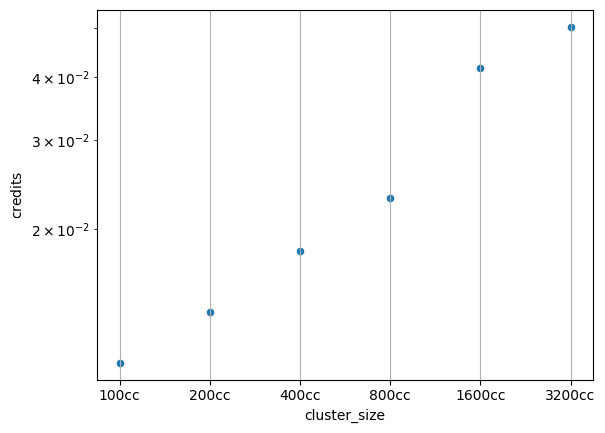

In [18]:
df2 = df[(df["mode"]=="strong") & (df["test_name"]=="create_index_primary_key")]
df2.plot(kind='scatter', x="cluster_size", y="credit_time", ylabel='$\\text{credits}$', logy=True, grid=True)
df2

,scenario,mode,category,test_name,cluster_size,repetition,size_bytes,time_ms,scenario_name,credits_per_h,credit_per_s,workers,throughput_mb_per_s,throughput_mb_per_s_worker,throughput_mb_per_credit,credit_time
78,tpcc_mv_sf_10,strong,materialized_view_formation,create_materialize_view,100cc,0,0,690062,tpcc_mv_sf,1.0,0.000278,2.0,0.0,0.0,0.0,0.191684
102,tpcc_mv_sf_10,strong,materialized_view_formation,create_materialize_view,200cc,0,0,311942,tpcc_mv_sf,2.0,0.000556,4.0,0.0,0.0,0.0,0.173301
126,tpcc_mv_sf_10,strong,materialized_view_formation,create_materialize_view,400cc,0,0,146459,tpcc_mv_sf,4.0,0.001111,8.0,0.0,0.0,0.0,0.162732
150,tpcc_mv_sf_10,strong,materialized_view_formation,create_materialize_view,800cc,0,0,76876,tpcc_mv_sf,8.0,0.002222,16.0,0.0,0.0,0.0,0.170836
174,tpcc_mv_sf_10,strong,materialized_view_formation,create_materialize_view,1600cc,0,0,50930,tpcc_mv_sf,16.0,0.004444,31.0,0.0,0.0,0.0,0.226356
198,tpcc_mv_sf_10,strong,materialized_view_formation,create_materialize_view,3200cc,0,0,34028,tpcc_mv_sf,32.0,0.008889,62.0,0.0,0.0,0.0,0.302471


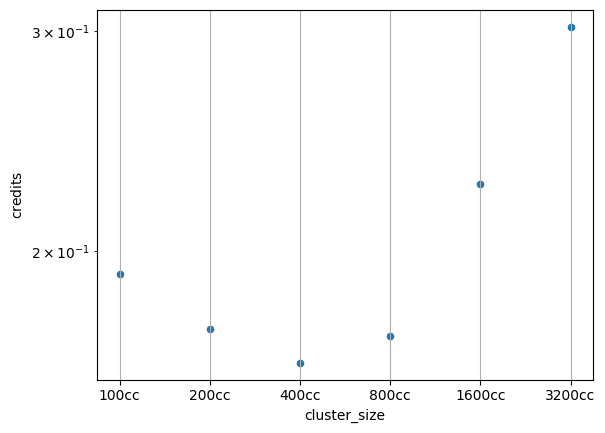

In [17]:
df2 = df[(df["mode"]=="strong") & (df["scenario"] == 'tpcc_mv_sf_10') & (df["test_name"]=="create_materialize_view")]
df2.plot(kind='scatter', x="cluster_size", y="credit_time", ylabel='$\\text{credits}$', logy=True, grid=True)
df2